<a href="https://colab.research.google.com/github/soulayman-al-abdallah/Data-Science-Projects/blob/main/Capstone_English_FLuency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mission: Creating a machine learning model that classifies the english language fluency of a voice segment**

- Data download
- Data Preparation
- Audio decomposition code into sub-audios
- Data preprocessing
- Feature Engineering
- Model design 
- Model testing
- Deploying needs

# **Data Preprocessing**

## Remove previous files

In [ ]:
#Delete a file
# import shutil

# shutil.rmtree('/content/Avalinguo-Audio-Set')

## Clonning the data

In [ ]:
import os
os.chdir('/content')

In [ ]:
! git clone https://github.com/agrija9/Avalinguo-Audio-Set

Cloning into 'Avalinguo-Audio-Set'...
remote: Enumerating objects: 1482, done.
remote: Total 1482 (delta 0), reused 0 (delta 0), pack-reused 1482
Receiving objects: 100% (1482/1482), 283.21 MiB | 25.94 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Checking out files: 100% (1430/1430), done.


## Feature Extraction functions

functions used to return the actual path of an audio file then extract features from the audio

In [ ]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf

##Return audio features 
def feature_extraction(file_name):
    #X, sample_rate = sf.read(file_name, dtype='float32')
    #print("feature_extraction")
    
    X , sample_rate = librosa.load(file_name, sr=None) #Can also load file using librosa
    if X.ndim > 1:
        X = X[:,0]
    X = X.T
    
    ## stFourier Transform
    stft = np.abs(librosa.stft(X))
            
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T, axis=0) #Returns N_mel coefs
    #print("mfcc: ",mfccs)
    rmse = np.mean(librosa.feature.rms(y=X).T, axis=0) #RMS Energy for each Frame (Stanford's). Returns 1 value 
    #print("rmse: ",rmse)
    spectral_flux = np.mean(librosa.onset.onset_strength(y=X, sr=sample_rate).T, axis=0) #Spectral Flux (Stanford's). Returns 1 Value
    #print("spectral_flux: ",spectral_flux)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=X).T, axis=0) #Returns 1 value
    #print("zcr:",zcr)
    
    ##Return computed audio features
    return mfccs, rmse, spectral_flux, zcr

# Audio parsing: Function makes call for feature extraction and returns array with features and labels 
def parse_audio_files(parent_dir, sub_dirs): # Audio Format

    n_mfccs = 20 # This variable is tunneable with each run
    number_of_features = 3 + n_mfccs
    #number_of_features = 154 + n_mfccs # 154 are the total values returned by rest of computed features
    features, labels = np.empty((0,number_of_features)), np.empty(0)
    
    ##Extract features for each audio file
    for label, sub_dir in enumerate(sub_dirs): ##The enumerate() function adds a counter to an iterable.
        file_name  = parent_dir+sub_dir
        #print("Actual File Name: ", file_name)
        try:
            mfccs, rmse, spectral_flux, zcr = feature_extraction(file_name)
            #mfccs, zcr, mel, chroma, contrast, tonnetz = feature_extraction(file_name)
        except Exception as e:
            #print("[Error] there was an error in feature extraction. %s" % (e))
            continue
          
        extracted_features = np.hstack([mfccs, rmse, spectral_flux, zcr])
        #extracted_features = np.hstack([mfccs, zcr, mel, chroma, contrast, tonnetz]) #Stack arrays in sequence horizontally (column wise)
        #print "Total Extracted Features: ", len(extracted_features) #This helps us identify really how many features are being computed
        features = np.vstack([features, extracted_features]) #Stack arrays in sequence vertically (row wise).
        labels = np.append(labels, label)
    #print("Extracted: ", features)
    return features,labels


Transforming  all audio to .wav

In [ ]:
number_of_files_low = len(os.listdir('/content/Avalinguo-Audio-Set/audio files/001 - Low'))
number_of_files_low

438

## Transforming to .wav

In [ ]:
import os
import librosa
import soundfile as sf

folder1 = r'/content/Avalinguo-Audio-Set/audio files/001 - Low/'
folder2 = r'/content/Avalinguo-Audio-Set/audio files/002 - Intermediate/'
folder3 = r'/content/Avalinguo-Audio-Set/audio files/003 - High/'

folders = [folder1,folder2,folder3]

# iterate all files from a directory
for folder in folders:
  for file_name in os.listdir(folder):
      # Construct old file name
      source = folder + file_name

      destination = folder + file_name + ".wav"

      # Renaming the file
      os.rename(source, destination)

      #Fixing the RIFF Bug
      audio , sample_rate = librosa.load(destination) 
      sf.write(destination, audio, sample_rate)

      

print('All Files Renamed')

print('New Names are')
# verify the result
res = os.listdir(folder)
print(res)

## ---Useless Getting the duration

**Getting the longest wave in our training audios to devide the long audio converted from the youtube video, by this length.**

In [ ]:
import wave
import contextlib

def get_longest_duration(folder_path):
  content = os.listdir(folder_path)
  durations  = []
  for file_path in content:
    for audio_path in os.listdir(folder_path+'/'+file_path):
      wav = folder_path+'/'+file_path+'/'+audio_path
      with contextlib.closing(wave.open(wav,'r')) as f:
          frames = f.getnframes()
          rate = f.getframerate()
          duration = frames / float(rate)
          durations.append(duration)

    return max(durations)

In [ ]:
max_duration = get_longest_duration('/content/Avalinguo-Audio-Set/audio files')

In [ ]:
max_duration

5.0

## Getting Directories and Sub directories

getting the name of each folder


In [ ]:
import os
arr = []
audio_parents = os.listdir("Avalinguo-Audio-Set/audio files/") #Path to data folder.
audio_parents.sort()
print('Audio parents: ', audio_parents)

Audio parents:  ['001 - Low', '002 - Intermediate', '003 - High']


Getting a matrix of 3 dim = 3 folders

In [ ]:
import os
folder1 = r'/content/Avalinguo-Audio-Set/audio files/001 - Low/'
folder2 = r'/content/Avalinguo-Audio-Set/audio files/002 - Intermediate/'
folder3 = r'/content/Avalinguo-Audio-Set/audio files/003 - High/'

folders = [folder1,folder2,folder3]

sub_dir = []
for folder in folders:
  audio_subdirectories = os.listdir(folder) #Path to data folder.
  audio_subdirectories.sort()
  sub_dir.append(audio_subdirectories)
print('Audio Subdirs: ', sub_dir)

Audio Subdirs:  [['Avalinguo - Dana and Konay segment 1 - D.wav', 'Avalinguo - Dana and Konay segment 10 - D.wav', 'Avalinguo - Dana and Konay segment 102 - D.wav', 'Avalinguo - Dana and Konay segment 103 - D.wav', 'Avalinguo - Dana and Konay segment 104 - D.wav', 'Avalinguo - Dana and Konay segment 108 - D.wav', 'Avalinguo - Dana and Konay segment 11 - D.wav', 'Avalinguo - Dana and Konay segment 110 - D.wav', 'Avalinguo - Dana and Konay segment 111 - D.wav', 'Avalinguo - Dana and Konay segment 113 - D.wav', 'Avalinguo - Dana and Konay segment 114 - D.wav', 'Avalinguo - Dana and Konay segment 115 - D.wav', 'Avalinguo - Dana and Konay segment 116 - D.wav', 'Avalinguo - Dana and Konay segment 117 - D.wav', 'Avalinguo - Dana and Konay segment 118 - D.wav', 'Avalinguo - Dana and Konay segment 119 - D.wav', 'Avalinguo - Dana and Konay segment 120 - D.wav', 'Avalinguo - Dana and Konay segment 122 - D.wav', 'Avalinguo - Dana and Konay segment 123 - D.wav', 'Avalinguo - Dana and Konay segment 

In [ ]:
len(sub_dir)

3

## Extracting the features

Extracting the features for each folder

In [ ]:
##Get features and labels
#This generates two numpy files. One npy file with feature vectors corresponding each audio file. The other with labels.

# Parse Audio Files Function Call
folder1 = r'/content/Avalinguo-Audio-Set/audio files/001 - Low/'
folder2 = r'/content/Avalinguo-Audio-Set/audio files/002 - Intermediate/'
folder3 = r'/content/Avalinguo-Audio-Set/audio files/003 - High/'


features_low, labels_low = parse_audio_files(folder1, sub_dir[0]) #folder path = low, high,... and sub = list of audios
features_inter, labels_inter = parse_audio_files(folder2, sub_dir[1])
features_high, labels_high = parse_audio_files(folder3, sub_dir[2])


printing the features for each file

In [ ]:
'low = ',features_low,'inter= ',features_inter,'high= ',features_high

('low = ', array([[-3.54115448e+02,  9.07245255e+01,  5.38927412e+00, ...,
          2.51672547e-02,  1.52017462e+00,  8.19159614e-02],
        [-3.44382233e+02,  9.39955902e+01,  9.88725185e-01, ...,
          2.40430571e-02,  1.39691865e+00,  8.66292318e-02],
        [-2.99869537e+02,  9.35181046e+01, -1.42370176e+01, ...,
          5.03320508e-02,  1.88285232e+00,  1.08556677e-01],
        ...,
        [-3.37389862e+02,  8.99310913e+01, -3.24059448e+01, ...,
          1.90796889e-02,  1.67621458e+00,  1.26354076e-01],
        [-3.19946747e+02,  9.54031296e+01, -3.94399452e+01, ...,
          2.50515621e-02,  1.77185583e+00,  1.24504937e-01],
        [-2.96805634e+02,  8.79598312e+01, -4.38357277e+01, ...,
          3.41743007e-02,  1.65001428e+00,  9.48893229e-02]]), 'inter= ', array([[-1.26479149e+02,  4.90049553e+01, -6.67936249e+01, ...,
          4.27762717e-02,  1.09930217e+00,  2.10614240e-01],
        [-2.82592560e+02,  1.00963486e+02, -6.76967764e+00, ...,
          4.699089

## --Useless Saving Features and labels

saving all features and labels

In [ ]:
features = [features_low,features_inter,features_high]
labels = [labels_low,labels_inter,labels_high]
np.save('features.npy', features) 
np.save('label.npy', labels)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [ ]:
print(len(features[0][0]))
print(len(features[0]))
print(len(features))


23
438
3


--Useless Comparing 2 audio files with their features

In [ ]:
feature_extraction('/content/Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Dana and Konay segment 1 - D.wav')

(array([-354.11545   ,   90.724525  ,    5.389274  ,   32.070118  ,
          18.071709  ,    7.681085  ,    7.788122  ,    6.9265676 ,
          -0.92842776,   10.818269  ,   -4.7736073 ,    4.700338  ,
          -0.9105705 ,    2.7633455 ,   -1.2122535 ,    1.2149061 ,
          -3.5238574 ,    5.337571  ,   -7.745197  ,    4.8812933 ],
       dtype=float32),
 array([0.02516725], dtype=float32),
 1.5201746,
 array([0.08191596]))

In [ ]:
feature_extraction('/content/Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Dana and Konay segment 10 - D.wav')

(array([-344.38223  ,   93.99559  ,    0.9887252,   25.724497 ,
          20.250597 ,   10.061071 ,    9.964728 ,   17.441303 ,
         -10.368977 ,   13.406169 ,  -13.415509 ,    9.290127 ,
           4.3253284,    0.9755673,    2.3118322,    2.7589114,
          -2.682243 ,    8.720482 ,   -8.276575 ,    5.597077 ],
       dtype=float32),
 array([0.02404306], dtype=float32),
 1.3969187,
 array([0.08662923]))


# *Data Exploration*



## Loading the labels

In [ ]:
#Load Data
import numpy as np
labels = np.load('label.npy',allow_pickle=True) 

# For label integer  de-encoding
label_classes = np.array(['Low','Intermediate','High'])
print(label_classes)

['Low' 'Intermediate' 'High']


## Reading the datafram

In [ ]:
import pandas as pd
df = pd.DataFrame(features)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:540: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


,0
0,"[[-354.1154479980469, 90.72452545166016, 5.389..."
1,"[[-126.4791488647461, 49.00495529174805, -66.7..."
2,"[[-221.9895782470703, 128.7687530517578, -31.1..."


## --Useless Visuallizing the data

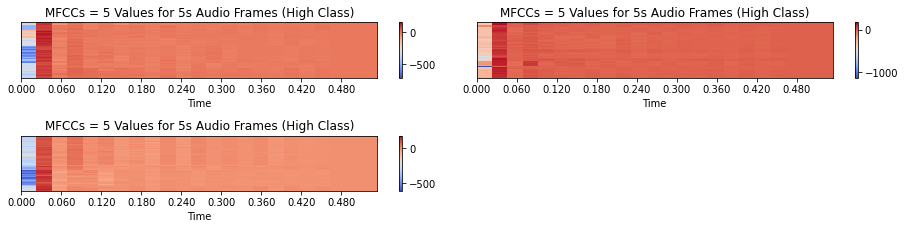

In [ ]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(13, 6))
for index,feature in enumerate(features):
  plt.subplot(4, 2, index+1)
  librosa.display.specshow(feature, x_axis='time')
  plt.colorbar()
  plt.title('MFCCs = 5 Values for 5s Audio Frames (High Class)')
  plt.tight_layout()
#plt.savefig('test saving.png')

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  "amplitude_to_db was called on complex input so phase "


Text(0.5, 1.0, 'Linear power spectrogram (grayscale)')

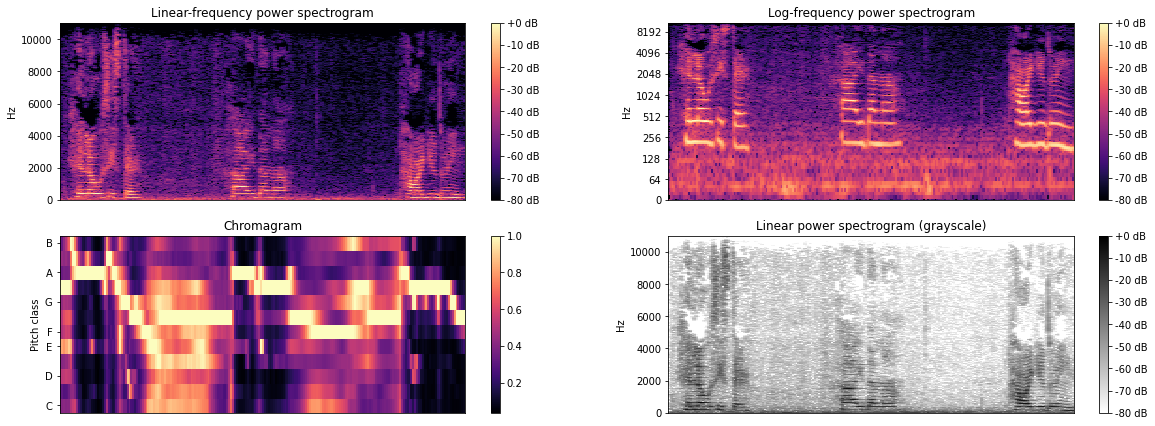

In [ ]:
#Visualize an STFT power spectrum
import matplotlib.pyplot as plt
y , sr = librosa.load('/content/Avalinguo-Audio-Set/audio files/001 - Low/Avalinguo - Dana and Konay segment 1 - D.wav', sr=None) # Using my own audio segment
#y, sr = librosa.load(librosa.util.example_audio_file())
plt.figure(figsize=(20, 15))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max) #Convert amplitude into db
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear') #Linear Scale
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# The above one on a logarithmic scale
plt.subplot(4, 2, 2)
#plt.figure(figsize=(20, 10))
librosa.display.specshow(D, y_axis='log') #Log scale
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

# Draw a chromagram with pitch classes
C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 3)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

#Force a grayscale colormap (white -> black)
plt.subplot(4, 2, 4)
librosa.display.specshow(D, cmap='gray_r', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear power spectrogram (grayscale)')

# ***CNN - Modelling***

## spliting the concatinated features arrays

In [ ]:
X = np.load("features.npy",allow_pickle=True)
y_mod = []
X_mod = []
for index,classs in enumerate(X):#classs = features low, index = 0
  for audio in classs:
      if index == 0:
        y_mod.append(0)
      elif index == 1:
        y_mod.append(1)
      elif index == 2:
        y_mod.append(2)
      X_mod.append(audio)

number_of_features = len(X_mod[1]) 
number_of_classes = 3

print("len of X = ",len(X_mod),"len of Y= ",len(y_mod))
print("")
print("X = ",X_mod[1300],"Y = ",y_mod[1300])

len of X =  1424 len of Y=  1424

X =  [-3.10007874e+02  6.52830200e+01  1.59653103e+00  4.62050247e+01
 -2.95278597e+00  2.29914227e+01 -1.14086170e+01  7.72795486e+00
 -6.59459352e+00  1.44443359e+01 -5.10946703e+00  1.64095726e+01
 -1.20662034e+00  1.34628725e+01 -3.62601304e+00  6.32606888e+00
 -7.62987852e+00  2.44888663e+00 -5.35356951e+00  7.72316813e-01
  2.17078086e-02  1.38115859e+00  1.33958605e-01] Y =  2


## Printing the shapes

In [ ]:
y = np.array(y_mod)
x = np.array(X_mod)

x[0],y[0]
x.shape,y.shape

((1424, 23), (1424,))

## encodding the output

In [ ]:
# Convert label to onehot
import tensorflow as tf

y_codded = tf.keras.utils.to_categorical(y, num_classes= number_of_classes)
y_mod[0],y_codded[0]

(0, array([1., 0., 0.], dtype=float32))

In [ ]:



unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0: 438, 1: 527, 2: 459}

In [ ]:
1424

## Splitiing the sets

In [ ]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y_codded, test_size = 0.3, random_state = 233)

# Need to reshape you data to have a spatial dimension for Conv1d to make sense
X_train = np.expand_dims(X_train, axis=2)# (100,2000) --> (100,2000,1)
X_test = np.expand_dims(X_test, axis=2)


## Model architecture

In [ ]:
# Neural Network Construction
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,GlobalAveragePooling1D,Dropout,Dense

model = Sequential()

# Neural Network Architecture
# Using 1D Convolutions (approriate for audio files)

# first layer has 64 convolution filters 
model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape = (number_of_features, 1))) 
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))

model.add(Dense(number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 23, 64)            256       
                                                                 
 conv1d_5 (Conv1D)           (None, 21, 64)            12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 64)            0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 7, 32)             6176      
                                                                 
 conv1d_7 (Conv1D)           (None, 7, 32)             3104      
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                             

## Fitting the model

In [ ]:
# Train Network
history1 = model.fit(X_train, y_train, batch_size=32, epochs=100,validation_data=(X_test, y_test))

Epoch 1/100
32/32 [==============================] - 1s 15ms/step - loss: 1.3041 - accuracy: 0.4629 - val_loss: 0.9355 - val_accuracy: 0.6075
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.9432 - accuracy: 0.5442 - val_loss: 0.8310 - val_accuracy: 0.5958
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.7994 - accuracy: 0.6325 - val_loss: 0.9345 - val_accuracy: 0.5164
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.7217 - accuracy: 0.6787 - val_loss: 0.6078 - val_accuracy: 0.7126
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.6176 - accuracy: 0.7189 - val_loss: 0.6608 - val_accuracy: 0.6963
Epoch 6/100
32/32 [==============================] - 0s 10ms/step - loss: 0.5806 - accuracy: 0.7390 - val_loss: 0.5156 - val_accuracy: 0.7944
Epoch 7/100
32/32 [==============================] - 0s 9ms/step - loss: 0.5566 - accuracy: 0.7520 - val_loss: 0.6423 - val_accuracy: 0.6682
Epoch 8/10

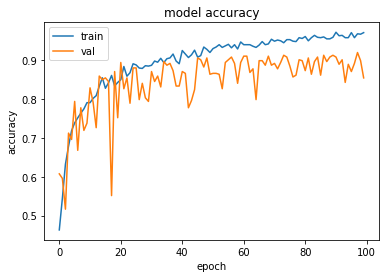

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

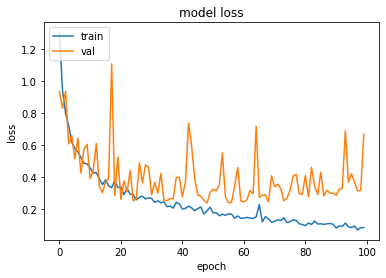

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/model_Fluency.h5')

In [ ]:
y_pred = model.predict(X_test)

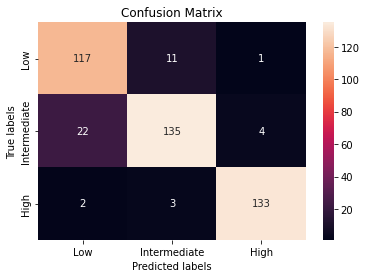

In [ ]:
from sklearn.metrics import confusion_matrix
labels = ['Low','Intermediate','High']
 
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

# **Deployment needs**

## Youtube link to audio .wav

In [ ]:
!pip install youtube_dl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# os.chdir('/content')

In [ ]:
from __future__ import unicode_literals
import youtube_dl
def audio_extraction(url):
  ydl_opts = {
      'format': 'bestaudio/best',
      'postprocessors': [{
          'key': 'FFmpegExtractAudio',
          'preferredcodec': 'wav',
          'preferredquality': '192',
      }],
  }
  with youtube_dl.YoutubeDL(ydl_opts) as ydl:
      info_dict = ydl.extract_info(url, download=False)
      name = ydl.prepare_filename(info_dict)
      duration = info_dict['duration']
      ydl.download([url])
  name = name.split('.webm')
  name = name[0]
  name = name.split('.m4a')

  audio = '/content/'+name[0]+'.wav'
  return audio,duration

In [ ]:
print(youtube_dl.version)


<module 'youtube_dl.version' from '/usr/local/lib/python3.7/dist-packages/youtube_dl/version.py'>


In [ ]:
# used to check the used version of the library

# import libsndfile
# import numpy as np
# import pandas as pd
# import librosa
# import pydub
# import youtube_dl
# import watermark
# import tensorflow
# import keras
# import soundfile


# %load_ext watermark
# %watermark -v -p numpy,tensorflow,jupyterlab,pandas,librosa,pydub,youtube_dl,keras,soundfile,libsndfile

## Returning the features of the new inputted audio CALLED in Scketch predictions

In [ ]:
def return_Input(mfccs, rmse, spectral_flux, zcr):
  extracted_features = np.hstack([mfccs, rmse, spectral_flux, zcr])
  #print(extracted_features.shape)
  features = np.expand_dims(extracted_features, axis=1)
  #print(x.shape)
  features = np.expand_dims(features, axis=0)
  #print(x.shape)
  return features

## Predicting the fluency of a each Sketch CALLED LATER

In [ ]:
def Predict_sketch(sketch_path):
  mfccs, rmse, spectral_flux, zcr = feature_extraction(sketch_path)
  input_features = return_Input(mfccs, rmse, spectral_flux, zcr)
  pred = model.predict(input_features)
  return np.argmax(pred)

## Creates sub Audios from an Audio CALLED LATER

In [ ]:
! pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pydub import AudioSegment
import shutil
def sub_audios_creation(audio_path, dur_cut, actual_dur, folder_name= "/content/sample_data/Testing"):
  try:
    shutil.rmtree(folder_name)
  except:
    x = 0
  os.mkdir(folder_name)
  count = 0
  max = dur_cut*1000
  while(count*dur_cut < actual_dur): #5*counter < 
    newAudio = AudioSegment.from_wav(audio_path)
    newAudio = newAudio[count*max:(count+1)*max]
    newAudio.export(f'{folder_name}/new{count}.wav', format="wav")
    count +=1

  return folder_name



## Return the predicted fluency of all sketches

In [ ]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

def Predict(url,model,cutdur,folder_path="/content/sample_data/Testing"):
  sketches_predictions = []
  audio,duration = audio_extraction(url)
  print("duration = ",duration)

  sketches_path = sub_audios_creation(audio,cutdur,duration,folder_path)

  for sketch_path in os.listdir(sketches_path):
    sketches_predictions.append(Predict_sketch(folder_path+'/'+sketch_path))

  #defined_list = [0,1,2]
  #curr_frequency = [sketches_predictions.count(i) for i in defined_list] #[100,20,30]
  print(sketches_predictions)
  return sum(sketches_predictions)/len(sketches_predictions)
  
  

In [ ]:
Predict('https://youtu.be/npvJpe3F_0o',model,5,"/content/sample_data/Testing" )

[youtube] npvJpe3F_0o: Downloading webpage
[youtube] npvJpe3F_0o: Downloading MPD manifest
[youtube] npvJpe3F_0o: Downloading webpage
[youtube] npvJpe3F_0o: Downloading MPD manifest
[download] Destination: Amixr (Batch 26 Digital Demo Day)-npvJpe3F_0o.m4a
[download] 100% of 1.83MiB in 00:23
[ffmpeg] Correcting container in "Amixr (Batch 26 Digital Demo Day)-npvJpe3F_0o.m4a"
[ffmpeg] Destination: Amixr (Batch 26 Digital Demo Day)-npvJpe3F_0o.wav
Deleting original file Amixr (Batch 26 Digital Demo Day)-npvJpe3F_0o.m4a (pass -k to keep)
duration =  119
[1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]


0.75